# Create data for stacking code testing

In [11]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes

In [12]:
data_path = Path("/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/")
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [13]:
tile = "80613"
tile_path = data_path / tile /"deep"

In [14]:
z_table = Table()
spectra = desispec.spectra.Spectra()

for file_path in tile_path.glob("zbest-*"):

    z_petal = Table.read(file_path, hdu="ZBEST")
    fibermap_petal = Table.read(file_path, hdu="FIBERMAP")[0:500]

    merged_table = join(z_petal, fibermap_petal, keys="TARGETID", metadata_conflicts="silent")
    print(len(merged_table))
    mask = ((merged_table["SV1_BGS_TARGET"] & bgs_mask.mask("BGS_BRIGHT"))>0) & (merged_table["FIBERSTATUS"] == 0)
    rfmag = 22.5 - 2.5 * np.log10(merged_table["FIBERFLUX_R"])
    mask &= (rfmag<19)
    mask &= (merged_table["Z"]>0.1) & (merged_table["Z"]<0.2)
    mask &= (merged_table["SPECTYPE"]=="GALAXY")
    mask &= (merged_table["DELTACHI2"]>1000)
    merged_table = merged_table[mask]
#     z_table = vstack([z_table, merged_table])

    if np.sum(mask):
        spec = desispec.io.read_spectra(str(file_path).replace("zbest","coadd") )
        # CAUTION desispec uses EXPID + FIBER to determine uniqueness
#         spec.fibermap["NIGHT"] = np.arange(len(spec.fibermap))
#         spec.fibermap["EXPID"] = np.arange(len(spec.fibermap))
        spec = myspecselect.myspecselect(spec,targets= merged_table["TARGETID"])

        z_table = vstack([z_table, merged_table])
        spectra = myspecupdate.myspecupdate(spectra, spec)

500


<ipython-input-14-1740dec2fd6a>:12: RuntimeWarning: invalid value encountered in log10
  rfmag = 22.5 - 2.5 * np.log10(merged_table["FIBERFLUX_R"])


INFO:spectra.py:253:read_spectra: iotime 0.852 sec to read coadd-0-80613-deep.fits at 2021-04-07T12:56:00.123937
500
INFO:spectra.py:253:read_spectra: iotime 0.917 sec to read coadd-1-80613-deep.fits at 2021-04-07T12:56:01.890292
500
INFO:spectra.py:253:read_spectra: iotime 0.980 sec to read coadd-7-80613-deep.fits at 2021-04-07T12:56:03.550325
500
INFO:spectra.py:253:read_spectra: iotime 0.909 sec to read coadd-3-80613-deep.fits at 2021-04-07T12:56:05.224832
500


<ipython-input-14-1740dec2fd6a>:12: RuntimeWarning: divide by zero encountered in log10
  rfmag = 22.5 - 2.5 * np.log10(merged_table["FIBERFLUX_R"])


INFO:spectra.py:253:read_spectra: iotime 0.902 sec to read coadd-5-80613-deep.fits at 2021-04-07T12:56:06.938103
500
INFO:spectra.py:253:read_spectra: iotime 0.890 sec to read coadd-9-80613-deep.fits at 2021-04-07T12:56:08.529514
500
500
INFO:spectra.py:253:read_spectra: iotime 0.738 sec to read coadd-8-80613-deep.fits at 2021-04-07T12:56:10.177747
500
INFO:spectra.py:253:read_spectra: iotime 0.844 sec to read coadd-4-80613-deep.fits at 2021-04-07T12:56:11.763279
500


In [21]:
z_table.columns

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','NUMEXP','NUMTILE','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','PRIORITY','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKID','BRICK_OBJID','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','BRICKNAME','EBV','FLUX_W1','FLUX_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_MWS_TARGET','DESI_TARGET','BGS_TARGET','MWS_TARGET','NUM_ITER','FIBER_X','FIBER_Y','DELTA_X','DELTA_Y','FIBER_RA','FIBER_DEC','EXPTIME','NIGHT','EXPID','MJD

In [16]:
spectra.num_targets()

16

Text(0.5, 0, 'Spec-Z')

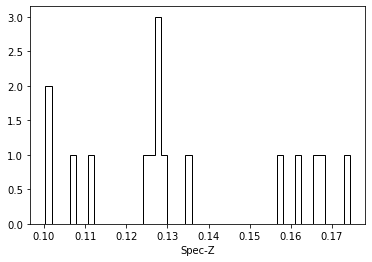

In [17]:
_=plt.hist(z_table["Z"], histtype="step", color="k", bins=50)
plt.xlabel("Spec-Z")

Text(0.5, 0, 'Spec-Z')

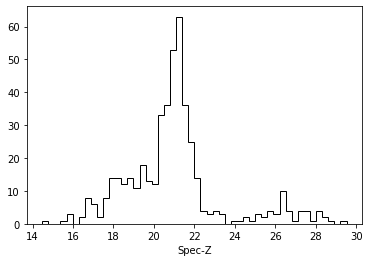

In [8]:
_=plt.hist(rfmag, histtype="step", color="k", bins=50)
plt.xlabel("Spec-Z")

In [18]:
z_table.write(my_path/"zcat_bright.fits")
desispec.io.write_spectra(my_path/"spectra_bright.fits", spectra)

INFO:spectra.py:154:write_spectra: iotime 5.347 sec to write spectra_bright.fits at 2021-04-07T12:57:29.485401


'/global/cscratch1/sd/bid13/stack-spectra/spectra_bright.fits'

In [19]:
spectra = coadd_cameras(spectra) #Coadding the cameras now but needs to be treated separately in future
                                # Moreover this needs a whole DESI spectra object and is very slow. Possible way out is to reimplrment a lighter version of this.
desispec.io.write_spectra(my_path / "spectra_coadd_cam_bright.fits", spectra)

INFO:spectra.py:154:write_spectra: iotime 16.245 sec to write spectra_coadd_cam_bright.fits at 2021-04-07T12:57:50.548688


'/global/cscratch1/sd/bid13/stack-spectra/spectra_coadd_cam_bright.fits'

In [ ]:
plt.plot(spectra.flux["brz"][8])

In [ ]:
sky = desispec.io.read_spectra("/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80609/deep/coadd-0-80609-deep.fits")

In [ ]:
x = sky.flux["b"][sky.fibermap["OBJTYPE"]=="SKY"]

In [ ]:
plt.plot(x[0])

# Curate the sky spectra